# TSFM Client - Demo Examples

This notebook demonstrates the TSFM client with examples:
1. Univariate prediction with ground truth, Chronos and Toto models
2. Multivariate prediction with two dependent time series using Toto model

Both examples use confidence intervals [0.80, 0.90, 0.95] and 100 samples.

In [6]:
# !pip install tsfm_client

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

 # Set up  TSFM_API_KEY first

In [8]:

#either provide it here
# os.environ['TSFM_API_KEY'] = ""

api_key = os.getenv('TSFM_API_KEY')
if not api_key:
    raise ValueError("Please set TSFM_API_KEY environment variable")


In [9]:
# Setup

# Import TSFM client
from tsfm_client import TSFMClient

# Configuration - using default base_url
client = TSFMClient(api_key=api_key)


In [11]:
# set up the basic parameters
CONFIDENCE_INTERVALS = [0.80, 0.90, 0.95]
NUM_SAMPLES = 100

## Example 1: Univariate Prediction

Compare ground truth with Chronos and Toto model predictions using confidence intervals [0.80, 0.90, 0.95].

In [2]:
# Generate synthetic univariate data
np.random.seed(42)

train_length = 80
test_length = 20
total_length = train_length + test_length

# Create time series with trend + seasonality + noise
t = np.arange(total_length)
trend = 0.3 * t + 25
seasonal = 8 * np.sin(2 * np.pi * t / 7)  # Weekly seasonality
noise = np.random.normal(0, 2, total_length)
full_series = trend + seasonal + noise

# Split into train/test
train_data = full_series[:train_length]
ground_truth = full_series[train_length:]

print(f"📊 Univariate data: {train_length} training points, {test_length} ground truth points")

# Get predictions from both models
models = [
    {'name': 'Chronos', 'model_name': 'chronos-t5-small', 'color': 'blue'},
    {'name': 'Toto', 'model_name': 'toto-open-base-1.0', 'color': 'red'}
]

predictions = {}

for model in models:
    print(f"🤖 Getting predictions from {model['name']}...")
    try:
        response = client.predict(
            model_name=model['model_name'],
            data=train_data.tolist(),
            forecast_horizon=test_length,
            confidence_intervals=CONFIDENCE_INTERVALS,
            num_samples=NUM_SAMPLES,
            time_interval_seconds=3600  # Hourly data
        )
        predictions[model['name']] = {'response': response, 'config': model}
        print(f"   ✅ Success! {len(response.forecast)} predictions with {len(response.confidence_intervals)} confidence intervals")
    except Exception as e:
        print(f"   ❌ Error: {str(e)}")
        predictions[model['name']] = {'error': str(e), 'config': model}

print(f"\n✅ Completed predictions from {len([p for p in predictions.values() if 'response' in p])} models")

📊 Univariate data: 80 training points, 20 ground truth points
🤖 Getting predictions from Chronos...
   ❌ Error: Request failed: The read operation timed out
🤖 Getting predictions from Toto...
   ❌ Error: Request failed: The read operation timed out

✅ Completed predictions from 0 models


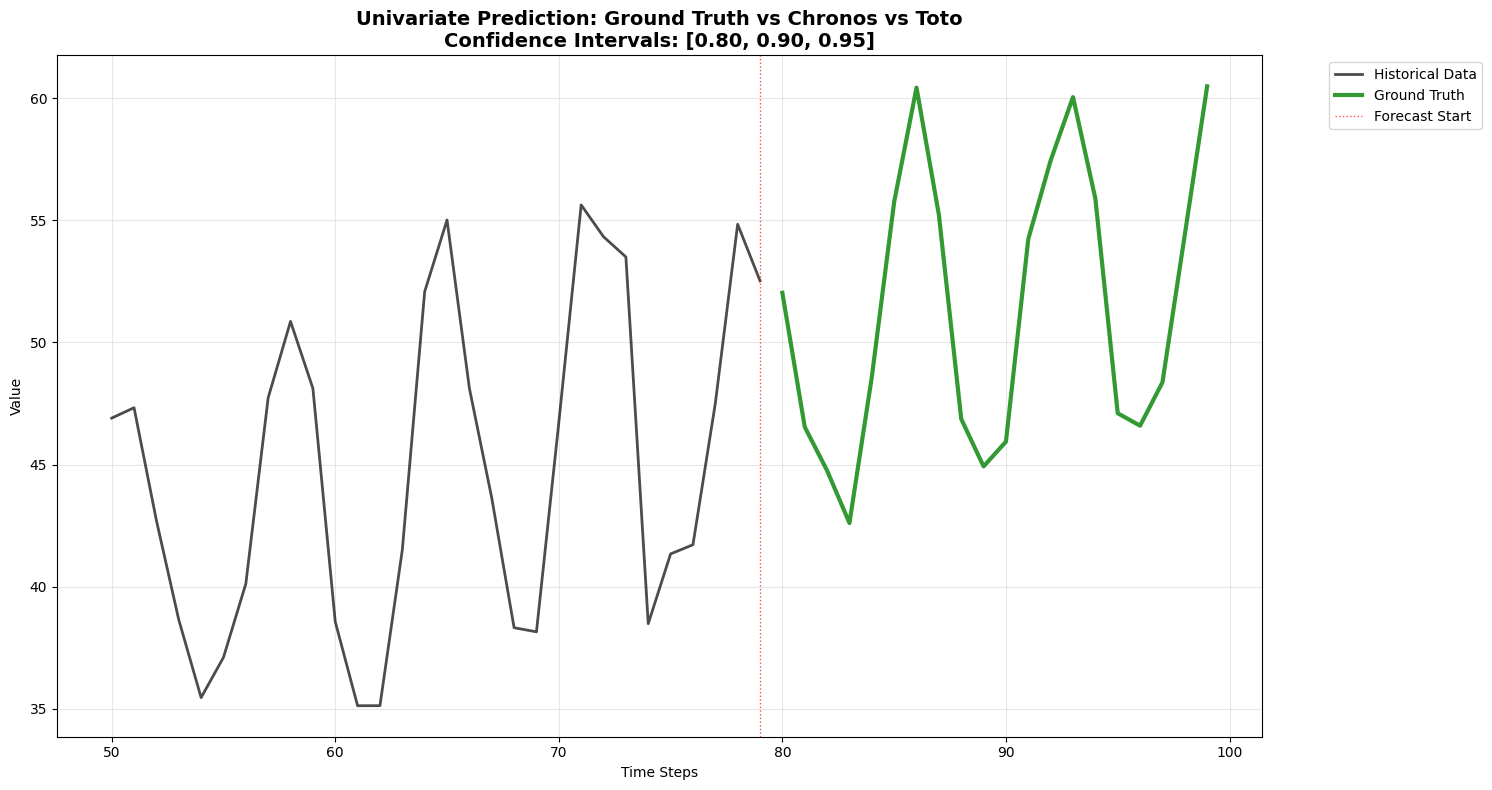


📊 Model Performance Comparison (MAE vs Ground Truth):
Chronos: Error - Request failed: The read operation timed out
Toto: Error - Request failed: The read operation timed out


In [3]:
# Plot univariate prediction results
plt.figure(figsize=(15, 8))

# Plot historical data (last 30 points)
historical_x = range(max(0, train_length-30), train_length)
historical_y = train_data[max(0, train_length-30):]
plt.plot(historical_x, historical_y, label='Historical Data', color='black', alpha=0.7, linewidth=2)

# Plot ground truth
truth_x = range(train_length, train_length + len(ground_truth))
plt.plot(truth_x, ground_truth, label='Ground Truth', color='green', linewidth=3, alpha=0.8)

# Plot predictions and confidence intervals
forecast_x = range(train_length, train_length + test_length)
alphas = [0.15, 0.25, 0.35]  # Different alphas for different CIs

for model_name, pred in predictions.items():
    if 'error' in pred:
        continue
    
    response = pred['response']
    config = pred['config']
    color = config['color']
    
    # Plot forecast median
    plt.plot(forecast_x, response.forecast, 
             label=f'{model_name} Forecast', color=color, linewidth=2, linestyle='--')
    
    # Plot confidence intervals
    if response.confidence_intervals:
        ci_items = sorted(response.confidence_intervals.items(), 
                         key=lambda x: float(x[0].rstrip('%')))
        
        for j, (ci_level, ci_data) in enumerate(ci_items):
            alpha = alphas[j % len(alphas)]
            plt.fill_between(forecast_x, ci_data['lower'], ci_data['upper'],
                           alpha=alpha, color=color, label=f'{model_name} {ci_level} CI')

plt.axvline(train_length-1, color='red', linestyle=':', alpha=0.7, linewidth=1, label='Forecast Start')
plt.title('Univariate Prediction: Ground Truth vs Chronos vs Toto\nConfidence Intervals: [0.80, 0.90, 0.95]', 
          fontweight='bold', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Performance comparison
print("\n📊 Model Performance Comparison (MAE vs Ground Truth):")
print("=" * 50)

for model_name, pred in predictions.items():
    if 'error' in pred:
        print(f"{model_name}: Error - {pred['error']}")
        continue
    
    response = pred['response']
    forecast = np.array(response.forecast)
    mae = np.mean(np.abs(forecast - ground_truth))
    
    print(f"{model_name}: MAE = {mae:.3f}")

## Example 2: Multivariate Prediction

Two dependent time series prediction using only the Toto model with confidence intervals [0.80, 0.90, 0.95].

In [ ]:
# Generate multivariate data with two dependent time series
np.random.seed(456)

n_points = 60
forecast_horizon = 15

t = np.linspace(0, 4*np.pi, n_points)

# Variable 1: Primary variable (e.g., temperature)
var1 = 20 + 5 * np.sin(t) + np.random.normal(0, 0.5, n_points)

# Variable 2: Dependent on Variable 1 (e.g., humidity inversely related to temperature)
var2 = 80 - 2 * var1 + 3 * np.cos(t/2) + np.random.normal(0, 1, n_points)

# Combine into multivariate format
multivariate_data = np.column_stack([var1, var2]).tolist()

print(f"📊 Multivariate data: {len(multivariate_data)} × {len(multivariate_data[0])} (time × variables)")
print(f"Variables: Temperature (primary), Humidity (dependent)")

# Get prediction from Toto model
print(f"\n🤖 Getting multivariate predictions from Toto...")

try:
    multivariate_response = client.predict(
        model_name='toto-open-base-1.0',
        data=multivariate_data,
        forecast_horizon=forecast_horizon,
        confidence_intervals=CONFIDENCE_INTERVALS,
        num_samples=NUM_SAMPLES,
        time_interval_seconds=1800  # 30-minute intervals
    )
    
    print(f"✅ Multivariate forecast successful!")
    print(f"   Input shape: {len(multivariate_data)} × {len(multivariate_data[0])}")
    print(f"   Forecast length: {len(multivariate_response.forecast)} (primary variable)")
    print(f"   Confidence intervals: {list(multivariate_response.confidence_intervals.keys())}")
    print(f"   Samples used: {multivariate_response.metadata.get('num_samples')}")
    
    multivariate_success = True
    
except Exception as e:
    print(f"❌ Multivariate prediction failed: {str(e)}")
    multivariate_success = False

📊 Multivariate data: 60 × 2 (time × variables)
Variables: Temperature (primary), Humidity (dependent)

🤖 Getting multivariate predictions from Toto...


In [ ]:
# Plot multivariate prediction results
if multivariate_success:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    historical_time = np.arange(n_points)
    forecast_time = np.arange(n_points, n_points + forecast_horizon)
    
    # Plot Variable 1 (Temperature) - the forecasted variable
    ax1.plot(historical_time, var1, label='Historical Temperature', color='red', linewidth=2)
    ax1.plot(forecast_time, multivariate_response.forecast, 
             label='Toto Forecast (Temperature)', color='red', linestyle='--', linewidth=3)
    
    # Plot confidence intervals for Variable 1
    colors = ['lightcoral', 'coral', 'orangered']
    alphas = [0.15, 0.25, 0.35]
    
    ci_items = sorted(multivariate_response.confidence_intervals.items(), 
                     key=lambda x: float(x[0].rstrip('%')))
    
    for i, (ci_level, ci_data) in enumerate(ci_items):
        color = colors[i % len(colors)]
        alpha = alphas[i % len(alphas)]
        ax1.fill_between(forecast_time, ci_data['lower'], ci_data['upper'],
                        alpha=alpha, color=color, label=f'{ci_level} CI')
    
    ax1.axvline(n_points-1, color='black', linestyle=':', alpha=0.7)
    ax1.set_title('Multivariate Prediction - Temperature (Primary Variable)\nToto Model with CI [0.80, 0.90, 0.95]', 
                  fontweight='bold', fontsize=12)
    ax1.set_ylabel('Temperature')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Variable 2 (Humidity) - input variable
    ax2.plot(historical_time, var2, label='Historical Humidity', color='blue', linewidth=2)
    ax2.axvline(n_points-1, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    ax2.set_title('Humidity (Input Variable - Dependent on Temperature)', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Humidity')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Multivariate Prediction Summary:")
    print("=" * 40)
    print(f"Model: {multivariate_response.model_name}")
    print(f"Input variables: 2 (Temperature, Humidity)")
    print(f"Forecast variable: Temperature (primary)")
    print(f"Forecast horizon: {len(multivariate_response.forecast)} steps")
    print(f"Confidence intervals: {list(multivariate_response.confidence_intervals.keys())}")
    print(f"Samples used: {multivariate_response.metadata.get('num_samples')}")
    
else:
    print("\n❌ Cannot plot multivariate results due to prediction failure.")

print("\n✅ Demo completed successfully!")
client.close()
print("🔐 Client connection closed.")